# PubChem validation
This notebook demonstrates a new (?) idea in LBVS validation - pinging the pubchem server for assays for a given compound / target pair, and assessing the Outcome field. 

The main difficulty/novelty here is automating the approach while ensuring it gets the CORRECT assay. This is because many targets have different names, and there is no standard format for assay descriptions *or* outcomes.

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

# Make some structure-predictions with label correlations:



In [8]:
#all labels:
interaction_matrix = sparse.load_npz('../0_data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../0_data/pchembl_chemicals.csv')
targets_df= pd.read_csv('../0_data/subset_targets.csv')

uniprots = pd.read_csv('./uniprot_accessions.csv').drop_duplicates(['chembl_id', 'accession', 'pref_name'])
targets_df = targets_df.merge(uniprots, on=['chembl_id', 'pref_name']).drop(['year', 'canonical_smiles', 'lig_chemblid'],axis=1)



In [9]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  1%|          | 613/95750 [00:00<00:31, 2976.09it/s]

y_in shape is: (358938, 344)


100%|██████████| 358938/358938 [00:59<00:00, 6000.53it/s]


In [15]:
train, test, fps = utils.load_time_split(year=2030, 
                                         return_fingerprints=True) #set a year after now to get ALL records

#now make all Known predictions very negative (so we don't sample them.)
labels_rows, labels_cols = interaction_matrix.nonzero()
probability_matrix[labels_rows,labels_cols] = -1e6

probability_arr = probability_matrix.toarray()



In [16]:
##sort the predictions in order of probability, highest first. 

arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
1.0
Should be a low number >= 0:
-1000000.0
Sorted array indices:


array([[105338,    270],
       [104580,    270],
       [105593,    167],
       ...,
       [173847,    101],
       [ 14008,    157],
       [ 59718,      6]])

In [17]:
#sanity check - make sure the ligand IDX, smiles, and target IDX and target names line up:

for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['lig_chemblid'].iloc[pair[0]]
    predicted_target = targets_df['pref_name'].iloc[pair[1]]
    tid = targets_df[targets_df['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)

CCCCOc1ncn... Dual specificity protein kinase CLK4 	 Dual specificity protein kinase CLK4
CHEMBL1996817 CCCCOc1ncnc2[nH]cc(c3ccccc3)c12
NS(=O)(=O)... Dual specificity protein kinase CLK4 	 Dual specificity protein kinase CLK4
CHEMBL1987034 NS(=O)(=O)c1cccc(Nc2ncc(Br)c(Nc3ccc(OCC#N)cc3)n2)c1
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc(NC(=O)Nc2ccc(cc2)c3csc4ncnc(N)c34)cc1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
COc1cc(Nc2... Mitogen-activated protein kinase kinase kinase kinase 4 	 Mitogen-activated protein kinase kinase kinase kinase 4
CHEMBL475251 COc1cc(Nc2ncc(F)c(Nc3ccc4OC(C)(C)C(=O)Nc4n3)n2)cc(OC)c1OC
COc1cc(Nc2... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL288441 COc1cc(Nc2c(cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc2

# PubChem-pinging 

This became much cleaner when wrapped in a class. The below uses a class to perform a number of functions:

- save/load checkpoints - i.e. if something breaks, or you want to come back to this later after shutting the laptop, you can save all the data and load it afterwards to pick back up
- ping `pubchempy` for compound ID (CID) numbers.
- ping `chembl_webresource_client` for target synonyms
- ping pubchem REST API for assays associated with a CID
- records all of this stuff in dicts to be saved as JSON so I can parse it later. 

In [18]:
class PubChemValidator(object):
    def __init__(self, targets_df, smiles, interaction_matrix, fps):
        self.tdf = targets_df
        self.interaction_matrix = interaction_matrix
        self.fps = fps
        self.smiles = smiles

        self.ligands = {}
        self.targets = {}
        self.predictions = {}

    def load_checkpoint(self, ligands=True, targets=True, predictions=True):
        if ligands:
            self.ligands = json.load(open('ligands.json', 'r'))
        if targets:
            self.targets = json.load(open('targets.json', 'r'))
        if predictions:
            self.predictions = json.load(open('predictions.json', 'r'))

    def save_checkpoint(self, ligands=True, targets=True, predictions=True):
        with open('ligands.json', 'w') as fp:
            json.dump(self.ligands, fp, indent=4,)
        with open('targets.json', 'w') as fp:
            json.dump(self.targets, fp, indent=4,)
        with open('predictions.json', 'w') as fp:
            json.dump(self.predictions, fp, indent=4,)

    def has_ligand(self, idx):
        if str(idx) in self.ligands:
            if 'smi' in self.ligands[str(idx)]:
                return True
        return False


    def has_target(self, idx):
        return str(idx) in self.targets

    def has_prediction(self, l_idx, t_idx):
        return str(l_idx)+':'+str(t_idx) in self.predictions

    def create_prediction(self, l_idx, t_idx, prob):
        record = dict()
        record['prob'] = str(prob)
        nn = self.get_nnrank_of_target(l_idx, t_idx)
        record['nn'] = nn

        self.predictions[str(l_idx)+':'+str(t_idx)] = record

    def create_target(self, idx):
        self.targets[str(idx)] = dict()
        record = self.targets[str(idx)]

        pref_name = self.tdf['pref_name'].iloc[idx]
        tid = self.tdf[self.tdf['pref_name']==pref_name]['chembl_id'].iloc[0]
        accession = self.tdf[self.tdf['pref_name']==pref_name]['accession'].iloc[0]

        record['pref_name'] = pref_name
        record['tid'] = tid
        record['accession'] = accession

    def create_ligand(self, idx):
        self.ligands[str(idx)] = dict()
        record = self.ligands[str(idx)]

        smi = smiles['canonical_smiles'].iloc[idx]
        chemblid = smiles['lig_chemblid'].iloc[idx]
        cid = self.get_cid(smi)
        
        #now get active assays:
        aids = self.get_assays_given_cid(cid, activity='active')
        active_accessions = self.get_uniprot_accession_from_aid(aids)
        
        #now get inactive assays:
        aids = self.get_assays_given_cid(cid, activity='inactive')
        inactive_accessions = self.get_uniprot_accession_from_aid(aids)

        record['smi']=smi
        record['chemblid'] = chemblid
        record['cid'] = cid
        record['actives'] = active_accessions
        record['inactives'] = inactive_accessions
        
################################    
    def get_assays_given_cid(self, cid, activity='active'):
        url  = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'
        url += str(cid)
        url += '/aids/JSON?aids_type='
        url += activity

        out = json.loads(requests.get(url).content)
        assay_ids = self.get_aids_from_pugrest_output(out)
        return assay_ids
    
    def get_uniprot_accession_from_aid(self, assay_ids):
        accession_dict = {}
        while len(assay_ids)>0:
            end = min(400, len(assay_ids))
            aids = assay_ids[:end]
            concat_aids = ','.join(aids)

            url  = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'
            url += concat_aids
            url +='/targets/ProteinAccession/JSON'
            out = json.loads(requests.get(url).content)

            accessions = self.parse_accessions_from_pugrest_output(out)
            accession_dict = {**accession_dict, **accessions}

            assay_ids = assay_ids[end:]

        return accession_dict
    
    def get_aids_from_pugrest_output(self, output):
        assay_ids = []
        if 'InformationList' in output.keys():
            assay_ids += [str(i) for i in output['InformationList']['Information'][0]['AID']]
        return assay_ids

    def parse_accessions_from_pugrest_output(self, output):
        accessions = {}
        if 'InformationList' in output.keys():
            for aid in output['InformationList']['Information']:
                if 'ProteinAccession' in aid:
                    available_accessions = aid['ProteinAccession']
                    for accession in available_accessions:
                        if '_' not in accession:
                            accessions[aid['AID']] = accession
        return accessions


################################
    def get_cid(self, smi):
        try:
            c = pcp.get_compounds(smi, 'smiles')[0]
            return c.cid
        except Exception as e:
            print(e)
            return 'cid_failed'
    
    def get_nnrank_of_target(self, ligand_idx, target_idx):
        positives = self.interaction_matrix[ligand_idx].nonzero()[1]
        all_distances = self.fast_jaccard(self.fps[ligand_idx], self.fps)[0]
        s = np.argsort(all_distances)

        pred = target_idx
        curr_rank = 0
        count=1
        preds = []
        seen = []

        while pred not in seen:
            predictions = self.interaction_matrix[s[count]].nonzero()[1]
            preds = np.setdiff1d(predictions,positives)
            preds = np.setdiff1d(preds, seen)
            curr_rank = len(seen)
            seen += list(preds)
            if len(preds)>0:
                 curr_rank+= np.mean(np.arange(len(preds))+1)
            count+=1

        return curr_rank
    
    ##The following is to calculate AVE bias:
    def fast_jaccard(self, X, Y=None):
        """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
        if isinstance(X, np.ndarray):
            X = sparse.csr_matrix(X)
        if Y is None:
            Y = X
        else:
            if isinstance(Y, np.ndarray):
                Y = sparse.csr_matrix(Y)
        assert X.shape[1] == Y.shape[1]

        X = X.astype(bool).astype(int)
        Y = Y.astype(bool).astype(int)
        intersect = X.dot(Y.T)
        x_sum = X.sum(axis=1).A1
        y_sum = Y.sum(axis=1).A1
        xx, yy = np.meshgrid(x_sum, y_sum)
        union = ((xx + yy).T - intersect)
        return (1 - intersect / union).A

In [29]:

pcv = PubChemValidator(targets_df, smiles, interaction_matrix, fps)
#pcv.load_checkpoint()

# How many predictions to sample, and which ones?

Ideally we want to sample a good few predictions that have high probabilities. But we also want to see how well it performs at lower probabilities. The problem is that even sampling over the highest, say, 10,000,000 predictions will be highly biased toward lower probabilities! So we try to weight the random selection to balance it out, selection an even number of high- and low-scoring predictions.

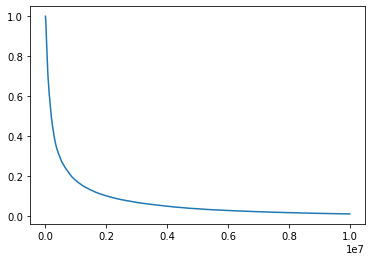

In [20]:
num = 10_000_000
probs = probability_arr[arr_sorted[:,0][:num], arr_sorted[:,1][:num]]
plt.plot(probs)

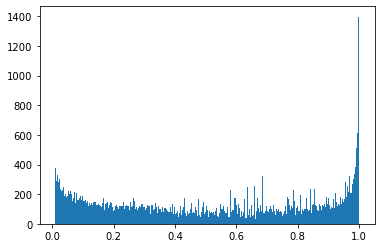

In [28]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(10*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

# Do the sampling.


In [34]:
import tqdm
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), 
                                            total=40000,
                                           smoothing=0):
    
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    
    if ligand_idx == 19434:
        continue
    
    try:
    
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
       
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        #if the ligand has any active or inactive assays, we will save them:
        actives = pcv.ligands[str(ligand_idx)]['actives']
        inactives = pcv.ligands[str(ligand_idx)]['inactives']
        if (len(actives) + len(inactives)) > 0:
            #then record the prediction:
            if not pcv.has_prediction(ligand_idx, target_idx):
                pcv.create_prediction(ligand_idx, target_idx, probability)
                
                
    except KeyboardInterrupt:
         raise
    except Exception:
         pass

    if count>0 and count%100==0:
        pcv.save_checkpoint()



/home/lewis/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


[285098    167]
[201173    172]
[282552    149]
[103945    171]
[227386     95]
[141063    261]
[232038     58]
[121795     56]
[338417    171]
[77639   343]
[259232    183]
[113157    229]
[164609     45]
[229746    270]
[5203   90]
[329520    299]
[223655    120]
[104248     71]
[141438    270]
[105463    272]
[105133     45]
[147780     91]
[276370    109]
[241281     41]
[142056    149]
[310631    270]
[191321     43]
[7574  121]
[161718     87]
[149259     51]
[180928    220]
[51654   118]
[145653    343]
[104470     88]
[103239     55]
[289438     87]
[250864    171]
[105433    272]
[221219     51]
[60286   123]
[350473    303]
[186077     95]
[329341    266]
[105874    127]
[255268    206]
[256650    206]
[211613     31]
[33867   144]
[105880    194]
[343821    154]
[300625    188]
[256754     87]
[234966    343]
[89266   122]
[279742    230]
[329663    105]
[104626    230]
[121147    185]
[2238  239]
[109553    159]
[246838    241]
[114599    171]
[296349    227]
[163596    149

[298080     31]
[104939     79]
[102814    107]
[211216    258]
[304465     91]
[118233     42]
[262891    327]
[15434   155]
[190980    154]
[353820    216]
[227330    167]
[103304    271]
[357192    246]
[43646   216]
[346815    147]
[222262    190]
[121295    122]
[175433    200]
[34134     8]
[199194    204]
[240448    167]
[76060   245]
[149753    325]
[158436     44]
[10341   172]
[105244      0]
[266006    313]
[122775    155]
[186087    239]
[197050    167]
[104081    275]
[187683    171]
[105272     39]
[146987    272]
[104580    254]
[356070    167]
[224566    254]
[127733    205]
[103411    194]
[102966    204]
[103968     95]
[60272   261]
[253590    271]
[181927    167]
[236803    254]
[105540    149]
[103588    192]
[339257     83]
[341141    228]
[76696   197]
[317393    138]
[80892   146]
[103720     75]
[168021     82]
[232024    165]
[103173    260]
[150764    168]
[220530    109]
[349561    171]
[103187    119]
[104174    185]
[340443     22]
[342753     74]
[332346 

[223907    294]
[106052    204]
[165702    220]
[305144    326]
[25033   180]
[234263    161]
[131332     88]
[106818    270]
[120188    270]
[126851     21]
[285633    146]
[155000    239]
[260638    190]
[90946   196]
[152439    107]
[155400    260]
[327352    261]
[210584    254]
[8357   65]
[181926    313]
[357081    119]
[153273     42]
[105636    325]
[103640    327]
[190685     27]
[169342    130]
[103118    327]
[104943    165]
[333070    119]
[19878    55]
[105181     75]
[309972    149]
[104097     42]
[111886    251]
[257992    276]
[311078    167]
[348533    200]
[319984    141]
[112670     29]
[354936    248]
[313438    275]
[191762    315]
[103049     29]
[104361     27]
[105713    329]
[254358    260]
[35052   228]
[103376    109]
[276890    173]
[186102    261]
[104738     42]
[104686    230]
[105770    235]
[210273    293]
[137325    167]
[104474    107]
[155589    154]
[328948     42]
[105604    151]
[31936   215]
[134245    124]
[101875    136]
[327343    261]
[22365

[309818    216]
[93896   229]
[31941   116]
[157793    233]
[210998    184]
[104824    269]
[186735    183]
[134209    204]
[340904    190]
[267683     58]
[327933    105]
[116232    260]
[205569    190]
[293153    167]
[103968    239]
[251441    343]
[103632    107]
[258536    303]
[254981    287]
[103322    270]
[1910  295]
[229930    241]
[104533    227]
[124167    173]
[346262    216]
[78518   238]
[166041    200]
[104986    325]
[44172   149]
[297723    204]
[109102    326]
[284912    311]
[158661    201]
[103459    269]
[105732    303]
[85567    97]
[6471   34]
[38108   153]
[331272    201]
[74584   179]
[323048     27]
[335086     91]
[338746     75]
[279949    178]
[103434    194]
[143004    204]
[220513     71]
[230076    146]
[155646    326]
[125059    141]
[315216     87]
[90171   223]
[86687   210]
[104411    188]
[49123    12]
[183197    181]
[71449   155]
[104430    230]
[105159    291]
[102894    254]
[94086     0]
[42880   229]
[103062    107]
[83348   201]
[222362    2

[54592   213]
[126621    258]
[253403    108]
[261274    327]
[97235   167]
[30536   211]
[171613    232]
[18383   190]
[86023    45]
[136406     94]
[105198    223]
[96895     0]
[273175    190]
[87908   146]
[20911     1]
[257329    183]
[289468    227]
[265732    150]
[6976  142]
[17469   119]
[104043    223]
[354281    190]
[249284    185]
[66050   215]
[271869    185]
[221957    185]
[110503    270]
[105361    272]
[237447    216]
[3080  290]
[342159    131]
[147130    180]
[66973   215]
[200994     52]
[104546    325]
[145225    184]
[104300    169]
[20498    78]
[272193    190]
[105819    167]
[158363     48]
[258610    173]
[208844     45]
[87711   115]
[79798   167]
[115346    127]
[248804    100]
[250375    200]
[186251     35]
[206870    260]
[159804    165]
[105654    343]
[175271    201]
[217163    139]
[11177   204]
[208209     75]
[104430    184]
[149276    248]
[136723    117]
[104764    149]
[334177    180]
[160083     79]
[102794    322]
[104559    290]
[98345   152]


[312302     35]
[103837    185]
[105363    251]
[306863    139]
[86940    91]
[104255    152]
[167047    101]
[103744     52]
[325572    326]
[108871    326]
[105468    230]
[105170    227]
[52667   215]
[36849   216]
[85962   172]
[233279    107]
[331760    146]
[216847    272]
[746  84]
[74130   171]
[103148     45]
[3523   87]
[293474    306]
[103165     61]
[120096    171]
[106136    251]
[104070    329]
[10243   185]
[9093  320]
[41108     6]
[177926    291]
[257927    120]
[3681  120]
[238196     91]
[105607    326]
[255887    293]
[104174    107]
[287483    251]
[347985    187]
[105225    276]
[334723     29]
[191724    119]
[247397    119]
[103791    185]
[214564     95]
[176862    180]
[334449    155]
[105986     27]
[215940    182]
[282656     71]
[752 154]
[279060    149]
[328867    313]
[25236   216]
[22070   146]
[146812     77]
[119392    101]
[18703   105]
[102885     29]
[80395    42]
[252471     27]
[290444    290]
[317462     68]
[206587    235]
[210438    258]
[12221

[296518    204]
[126154    215]
[92137   210]
[105897    239]
[18294   167]
[139310    184]
[11193   270]
[102891    149]
[287698     88]
[147517    329]
[108753    105]
[357691    103]
[37336   215]
[54715   123]
[176357    272]
[312068    326]
[345696    210]
[104541    196]
[104595     31]
[74864   251]
[310228    149]
[34445   218]
[102860    327]
[328873     31]
[275458    261]
[241267    327]
[48458    90]
[104797    172]
[103443    343]
[122262    130]
[347452    270]
[87128   266]
[105750    291]
[52392   215]
[299889    271]
[103137    235]
[15680   190]
[174037    117]
[291840     95]
[290437     88]
[116995    149]
[79617   118]
[103740    176]
[280620    227]
[356763    220]
[200250    211]
[173937    122]
[121102    197]
[25465   229]
[329307    160]
[105765    196]
[147517    150]
[354652    210]
[141775    103]
[342220    167]
[37704   213]
[102562    229]
[102935    171]
[39360   215]
[308952     88]
[8181  117]
[356670    228]
[329684     95]
[334563    159]
[286517   

[184992     95]
[83019   185]
[103376     75]
[104146    251]
[319458     97]
[314016    151]
[36685   215]
[115212    325]
[100597    194]
[343431    190]
[236823     45]
[80094   117]
[260558    258]
[1548   90]
[88174   107]
[279  55]
[345514    100]
[118469     95]
[271881     29]
[332973    322]
[99126   270]
[289403    103]
[103074    329]
[106023     58]
[342536    260]
[104784     51]
[20923   181]
[237492    117]
[106149    127]
[102859    107]
[77659    71]
[263397    204]
[15295   290]
[105533    276]
[258120    188]
[88190   231]
[335090     42]
[323849    185]
[108359     31]
[70297   194]
[206291    223]
[21277   268]
[104784    184]
[211772    325]
[266977    184]
[328123     88]
[151919     85]
[5669  324]
[313527    326]
[105979    272]
[201705    130]
[104721    271]
[162093    201]
[180760     77]
[233330    343]
[288350    325]
[136411     29]
[336278    325]
[204650    173]
[105689    251]
[184051    215]
[9493   91]
[112819    215]
[345769    101]
[201146    129]


[101770    183]
[358649    101]
[73976   100]
[104329     88]
[199220     65]
[62829   149]
[284956    169]
[41743   235]
[102931    230]
[106014      0]
[153313    329]
[334837    298]
[84911   155]
[205989    231]
[92464   192]
[106086    261]
[105596    264]
[105285     29]
[106070    329]
[37452   213]
[77658   165]
[104576    176]
[155160    343]
[170971    231]
[103541     31]
[55466   306]
[238191    100]
[103610    155]
[104750    156]
[217211     55]
[105701    276]
[23318     8]
[154922    121]
[205877    343]
[158322    228]
[104595     51]
[296294     31]
[10682   216]
[105459    107]
[185387    343]
[82910   184]
[72011   229]
[77644   290]
[195255    231]
[295520    223]
[99741    77]
[161023     45]
[104703    171]
[128704    213]
[165603    245]
[92366   115]
[258531     79]
[199268    220]
[114704    246]
[104678    156]
[104204    295]
[342672    176]
[102850    165]
[48128   216]
[239595    194]
[145208     87]
[321087    343]
[196457    117]
[139040    172]
[202479 

[336840    200]
[278627     58]
[293882    271]
[209978    281]
[123144    246]
[260256    230]
[320877     55]
[17384   184]
[102966    241]
[103434     27]
[106045    325]
[38930   118]
[202658    241]
[243324    235]
[105770    291]
[332910    167]
[99778   315]
[103087     58]
[162770    264]
[89968   120]
[5419  245]
[106105    176]
[294260    299]
[105159    171]
[257958    183]
[330438     90]
[292396    293]
[104951    155]
[103318     95]
[102766    270]
[103945    227]
[195273     77]
[103239    146]
[52743   180]
[309547    241]
[200953    167]
[88890   230]
[103596    290]
[128611    180]
[132965    269]
[37574    85]
[206494    275]
[276993    161]
[240863    155]
[319167    263]
[82919   261]
[186085    152]
[3029  272]
[351448    211]
[320923     68]
[318628    182]
[15684   152]
[190076    325]
[134620    270]
[28391   226]
[140884    184]
[277849    122]
[104813    176]
[315119    211]
[255136    184]
[105897    141]
[248812    215]
[320920    194]
[67989   229]
[14667

[331340    194]
[251981    343]
[4065   91]
[167819     77]
[105747    271]
[102827     65]
[184687    155]
[104416     75]
[11272   103]
[110315    196]
[97478    88]
[61697   180]
[22821   181]
[79536    14]
[104898     52]
[106143    313]
[204860     78]
[8999   84]
[113259    269]
[199704    122]
[104873    325]
[103868    188]
[327647    235]
[321050     65]
[20484   182]
[249468    154]
[26628   213]
[330349    108]
[71870   226]
[157826    124]
[34118   216]
[285337    194]
[179469     29]
[122259    130]
[12116   167]
[11017   235]
[120297    175]
[45299   229]
[307644    327]
[341418    137]
[339196    325]
[242893    254]
[85849   184]
[206615    269]
[215122    235]
[13462   103]
[102510     45]
[186374    303]
[141780     31]
[68075    22]
[131085    261]
[202615    185]
[165703    115]
[107015    121]
[179272     85]
[121087     88]
[103654     29]
[57198   215]
[104943    271]
[277678     65]
[103791     51]
[211555    324]
[161279    122]
[162499    160]
[129008    204]


[20356   100]
[247532    343]
[299673     29]
[246801     95]
[104005    151]
[243573    120]
[105692    165]
[357279    154]
[293604     91]
[71297   215]
[105779    194]
[259791    146]
[288836    184]
[123833     72]
[139327    205]
[145071    156]
[138706    154]
[106396    162]
[167452    198]
[297739     40]
[286587    275]
[297944    235]
[143006    245]
[105775    184]
[116766    185]
[232145    231]
[220685    319]
[223877    201]
[206934    197]
[241627    204]
[94870   176]
[295483    184]
[303456    184]
[105405     87]
[196966    341]
[23832    75]
[96315   146]
[135818    271]
[12142   213]
[293921     55]
[103255    155]
[165457    254]
[308797    167]
[285630    141]
[300437     87]
[106136     87]
[149077    196]
[105779    343]
[49776   216]
[338183     84]
[105273    159]
[214506      0]
[307080    200]
[93309   241]
[199921    171]
[349615    270]
[2286   88]
[45298   185]
[105432    326]
[102850    150]
[104229     71]
[223835     95]
[292315     40]
[222076    147

[103024     75]
[233839    245]
[105775    109]
[210905    216]
[2210  105]
[318959    120]
[105545    149]
[104583    271]
[68894   270]
[345264    275]
[6813   88]
[104189    324]
[2795  161]
[105085    245]
[103201      0]
[105311    272]
[220770    210]
[307260    167]
[292108    326]
[261408    241]
[316115    230]
[226317     29]
[252117    343]
[192756    251]
[149077     27]
[39547   201]
[345416     22]
[97176   293]
[233375    271]
[113953    199]
[104196     95]
[105876    204]
[144139    229]
[11546    91]
[182086    269]
[141058     88]
[39270    51]
[309971    176]
[281276    266]
[336482    159]
[340443     98]
[141198    283]
[151559    107]
[115556    325]
[134151    119]
[295856    155]
[265237    269]
[78197   201]
[146808    205]
[264190    269]
[105285     65]
[120103    168]
[324042    205]
[162578    192]
[25936   215]
[105093    260]
[104484    169]
[103062     71]
[102344    329]
[314081    105]
[24361   229]
[299395    149]
[135197    260]
[55126   180]
[82955

[24307   213]
[349337    180]
[128767     90]
[16693   108]
[73361    44]
[33323    53]
[194691    103]
[166640    223]
[105273    141]
[1335   62]
[103218    171]
[283853    161]
[141670    259]
[13753   228]
[253590    265]
[105303    343]
[103848     39]
[196728    223]
[27698     5]
[313138    303]
[93484   293]
[272249    241]
[151640    214]
[103975    171]
[14965   326]
[153024     59]
[15260   228]
[104635     75]
[276599    204]
[358566    136]
[25185    40]
[261985    216]
[281676    127]
[99106   235]
[350971    117]
[200389    228]
[115214     75]
[38189   123]
[113479    213]
[226516    120]
[176949    136]
[251901    258]
[103941    231]
[96309   120]
[104824    230]
[250066     41]
[105921     29]
[104751    171]
[84812    29]
[165142    230]
[1840   52]
[105934    309]
[102805    152]
[197326    231]
[193542    233]
[56455   107]
[253784    165]
[348291     49]
[105422    291]
[144222    181]
[342530     27]
[234224    271]
[344538     30]
[135197     51]
[184967     71

[322533    303]
[42942   118]
[102758    275]
[104146    343]
[105471    169]
[133201    270]
[154427    327]
[210371    199]
[282219    156]
[247321     46]
[102869     45]
[253276    167]
[294749    258]
[154171    143]
[335568    160]
[322759    233]
[325780    199]
[104402     75]
[93952    59]
[249657     55]
[169505    154]
[100576    105]
[64762    84]
[34128    88]
[338198     84]
[105253    275]
[190493    326]
[105471    287]
[104955     29]
[108829     75]
[104734    313]
[358725     82]
[75581   120]
[148480     35]
[350798    130]
[125059    127]
[264684     88]
[1157   35]
[282146    206]
[141431     42]
[105815    315]
[224549    167]
[8618  245]
[281744    168]
[105397    266]
[144935    215]
[329502     51]
[334981     31]
[150899    171]
[316686     31]
[122350    119]
[104942    329]
[134343     94]
[276158     88]
[93612   260]
[264743    194]
[37752     6]
[306446    258]
[223865     55]
[328468     79]
[311631    183]
[104180    216]
[315415     74]
[203309    167

[36439   216]
[119671    256]
[255989    269]
[92184   271]
[322081    136]
[106143    139]
[271389    167]
[337250     58]
[102796    167]
[273565    260]
[106023     55]
[136636    109]
[279457     29]
[149688    176]
[105815    303]
[146868    190]
[61272   268]
[105466    275]
[126475    109]
[314016     29]
[312647    327]
[117747     46]
[114902    241]
[106516    217]
[354739    172]
[10560   121]
[56502   231]
[227985    167]
[204924     31]
[56371    30]
[286871     88]
[85648   270]
[196048    343]
[25216    85]
[133734      0]
[275707    120]
[105775    261]
[133116    144]
[21887   111]
[189658    190]
[113964    197]
[105311    152]
[138705    205]
[155687    184]
[77500   315]
[106007    275]
[261914    235]
[24134   215]
[337262     84]
[75565   275]
[195267    205]
[116904    264]
[264427    107]
[105107    257]
[164313    228]
[158923    215]
[88252   271]
[333936    324]
[15503    22]
[205385    199]
[323943    188]
[149203    146]
[17221    65]
[103601    343]
[10598

[57497   215]
[61430   226]
[294188    326]
[266501     88]
[85494    24]
[295595    270]
[298895    227]
[214427    199]
[103753    295]
[103960    327]
[73247   229]
[295204    241]
[161712    291]
[270006     71]
[35818   213]
[46787   229]
[73732   333]
[318281     21]
[15430    95]
[59339   180]
[103700    109]
[95462   319]
[105468     42]
[105607    167]
[326151    213]
[135174    228]
[176585    101]
[146108     90]
[6062  149]
[306159    140]
[347670    180]
[104286    239]
[242425     87]
[178022    311]
[188965    129]
[182195    121]
[309998    138]
[256637     91]
[306661    295]
[103304     58]
[1911   71]
[135657     91]
[39873    78]
[140654    272]
[103438    260]
[105533    223]
[355661    119]
[40859   210]
[353446    103]
[106107    194]
[315293    228]
[166193    109]
[43357    24]
[274773    324]
[102885     58]
[168048    159]
[235142    171]
[104643    239]
[132612    167]
[317518    119]
[73667    29]
[324698    205]
[105342    155]
[118153    327]
[343370    2

[262624    146]
[5669  185]
[103118    261]
[104299    299]
[341702    122]
[104219    146]
[103067     27]
[106149    251]
[3183  101]
[262007     29]
[252578    204]
[313441    303]
[181344    185]
[90946   264]
[13709    91]
[148777    201]
[282903    319]
[89943   127]
[92186   315]
[348117    136]
[1385  241]
[103500    271]
[331560     56]
[233134     95]
[286595    272]
[355060    201]
[331642    205]
[104236     87]
[160777    313]
[325780    261]
[304078    327]
[247492    184]
[104671     95]
[326999     96]
[202459    300]
[324901    109]
[306862    325]
[104581    313]
[296172     88]
[297479     88]
[266458    159]
[302020     94]
[37428   215]
[313256    235]
[312698     55]
[48939   268]
[67399   216]
[25992   180]
[81372   275]
[261820    199]
[110063    165]
[57315   216]
[105948    109]
[323018     29]
[117410    248]
[29806   213]
[143388    155]
[220546     55]
[162327     30]
[174856    172]
[101917    270]
[112430    275]
[336972    241]
[105780    159]
[329649   

[305804    169]
[276950    266]
[82645   216]
[256582    283]
[320531    190]
[106091    120]
[103819    109]
[135851     83]
[238524    200]
[173472    180]
[115518     27]
[94232   205]
[95585   190]
[179932    272]
[103731    324]
[151205    270]
[270003    269]
[337419    223]
[104889    173]
[99025    30]
[89278   307]
[214742    120]
[33571   229]
[332240    260]
[104161     71]
[1771  129]
[118706    119]
[84419    27]
[287425    260]
[103699    167]
[190773    270]
[68502   180]
[39087   229]
[200292    322]
[257269    272]
[102827    235]
[279807    167]
[105924    241]
[159859    239]
[160468    204]
[105323    188]
[258117    155]
[105989    194]
[105590    230]
[33543    72]
[138633    211]
[103411    141]
[104776    173]
[61645   153]
[238325     39]
[142693    299]
[106052    299]
[271196    223]
[218538    171]
[252117    261]
[103223    343]
[153205    325]
[312097    169]
[103183     31]
[102918    176]
[103238    322]
[103001    161]
[138667    122]
[104463     51]
[2

[321539    107]
[186045    343]
[103055    313]
[313718     58]
[99544   117]
[167777    229]
[96924    95]
[82954   291]
[104384    315]
[103893    167]
[37629   215]
[103892    215]
[103753     79]
[103628    204]
[129904    185]
[63763    46]
[141769     79]
[246697    141]
[344225    154]
[105874    325]
[132745    184]
[184741    101]
[243527    245]
[131478     27]
[332343    155]
[50921   216]
[160848    201]
[347939    143]
[153765    105]
[200177     31]
[332299    204]
[252521     91]
[105897    184]
[300814     55]
[105967    241]
[94870    58]
[272630     29]
[104570    109]
[105303    239]
[90777   314]
[56621   146]
[188374    276]
[15680   107]
[317494    136]
[357546    153]
[11884   103]
[103049    196]
[354472    210]
[107441    229]
[95925   326]
[357525    168]
[182192    121]
[137331    154]
[77707   231]
[291107    173]
[104049     52]
[931 343]
[333703     94]
[136982    256]
[36713   229]
[157017     85]
[105119    329]
[295392    146]
[153094    144]
[40161    

[69762   226]
[247212    200]
[57777   188]
[74810    91]
[340040    230]
[15553   196]
[149418    146]
[55415   303]
[350313     24]
[334364    120]
[63701   226]
[143761     18]
[105677    127]
[119340    218]
[238178     91]
[240457    241]
[137248     87]
[168002    136]
[105444    303]
[63685   260]
[162577    325]
[33720   131]
[103649    155]
[332853    155]
[321539    270]
[76301   250]
[104140     51]
[253110    230]
[184384    143]
[144967    175]
[204586    295]
[167438    303]
[  0 303]
[84828   213]
[114734    136]
[105905    276]
[139269     85]
[74138    55]
[251995    303]
[352890    101]
[198439    122]
[104192    185]
[221886    184]
[73668   324]
[66526     6]
[176569    184]
[29529   216]
[102957    107]
[148777    211]
[351881     83]
[255626    143]
[196728    313]
[310369    264]
[145005    175]
[256885      0]
[104018    260]
[104431     42]
[104452     87]
[104045    127]
[95148   235]
[29272   180]
[137734    117]
[104710     29]
[256816    119]
[105931    260

[141057    184]
[338417    241]
[170870    123]
[249908    343]
[40696   216]
[235997     29]
[71591   213]
[38702   184]
[123292    149]
[105634     27]
[189524     77]
[126620    197]
[1935   31]
[174227    276]
[253161    155]
[3111  159]
[94049   343]
[105112    245]
[169413     21]
[228000     75]
[190668    269]
[157587    159]
[279988     58]
[199683     48]
[250851    245]
[105574    235]
[104916    169]
[233395    275]
[230674      5]
[105359    251]
[19013   264]
[84486   210]
[117381    119]
[103176    269]
[103632    161]
[263161    223]
[307249    167]
[224556     71]
[185344     90]
[149429    204]
[227979    167]
[102771    257]
[291171    161]
[145588    205]
[356319    210]
[202401    167]
[104029    120]
[271766    343]
[104474    188]
[251227    235]
[103018    149]
[45153     5]
[242550    325]
[121712     31]
[297687    327]
[57840   229]
[266595    303]
[329711    201]
[358031    272]
[109006    303]
[262059    121]
[212799    183]
[105530    271]
[104708    223]


[297092    241]
[86346   326]
[104721    227]
[93777   326]
[355136    165]
[171597    215]
[37398   260]
[206480     88]
[236171    242]
[104225     71]
[352493    154]
[345068    107]
[345220    100]
[7463   59]
[47116     1]
[135669    119]
[205372    199]
[100137    201]
[102905    241]
[344418    105]
[105572    223]
[103359    271]
[351451     36]
[344137    270]
[199637    175]
[176693    144]
[103254     79]
[332853     87]
[153246    108]
[205410    206]
[265996    188]
[223103    269]
[281633    291]
[125041     51]
[977  90]
[3905  205]
[246726    144]
[336171     27]
[104518    231]
[227525    204]
[307779    303]
[169326    210]
[147223    291]
[162159     90]
[271474     71]
[104398    223]
[338417    194]
[104821    235]
[105855    167]
[105289    109]
[79963   140]
[105535     55]
[102996    139]
[266435    258]
[157525     91]
[98339   245]
[84366    36]
[223922    211]
[314691    211]
[105289    151]
[100789     21]
[106143    269]
[207051    319]
[279147    258]
[174

[1867  107]
[126457     91]
[102957     55]
[264890     40]
[322383     51]
[258041     88]
[80255   107]
[255277    265]
[205810    230]
[326980    167]
[143014     45]
[332305    216]
[327677    229]
[135721    131]
[141785    343]
[217157    173]
[105515    107]
[292845    184]
[105168    227]
[30463   229]
[358574    100]
[104101    127]
[72334   213]
[201812     99]
[103388    343]
[115214    185]
[105613    120]
[146998    293]
[43536   268]
[180544     91]
[200434    235]
[273568    266]
[230475     71]
[253832    141]
[105072    276]
[206188    283]
[149500    241]
[103143    326]
[190078    204]
[128875    146]
[58236   118]
[84195   254]
[165214     83]
[233844    325]
[104269    171]
[139523    291]
[45438   216]
[102918    327]
[106120    120]
[350795    271]
[92242   239]
[340443    272]
[105967      0]
[281856    258]
[10974    91]
[66914   210]
[104049    149]
[105285    194]
[104943    251]
[344084    160]
[232936    258]
[295001    184]
[75559   251]
[229703    270]
[1

[14296   172]
[299456     42]
[2310  231]
[330164    146]
[71048   213]
[354402    201]
[243551    155]
[184288    140]
[104030     95]
[58374   229]
[142750    269]
[329520     39]
[120570    154]
[103324    194]
[102773    322]
[250066    270]
[102864    176]
[21973   309]
[104994    235]
[176262    139]
[148364    343]
[148031     75]
[103949     55]
[93975   184]
[120074    105]
[148692     27]
[259011     88]
[103233    295]
[81772   216]
[222738    167]
[347074    176]
[272963    131]
[327732    146]
[227372    271]
[103579     65]
[102891    261]
[321332    251]
[227197    251]
[189700    139]
[238227     91]
[257957    220]
[105665    184]
[109143    105]
[104750    192]
[103679    141]
[90005   241]
[357632    272]
[104251     41]
[104138    150]
[337450    260]
[265245     58]
[184673     77]
[73974   180]
[102762     58]
[43465   216]
[105366    185]
[51289   216]
[103513    204]
[325977    107]
[264569    204]
[103001    299]
[16866   205]
[102905     95]
[103156    204]
[2

[311956    315]
[274982    184]
[105272    324]
[103878    223]
[158291    168]
[1943  188]
[143361    293]
[109495    264]
[347577    290]
[118507    146]
[103417    264]
[343885    204]
[342910    188]
[149592    149]
[77656    65]
[288322    251]
[104660    324]
[113191    130]
[354211     96]
[133951    204]
[326652    103]
[180209     96]
[325719    144]
[304256     51]
[215142     79]
[152272     74]
[3352  109]
[70895   215]
[329690     53]
[105927    107]
[104555    291]
[52203   216]
[250616    188]
[58287   118]
[116318    154]
[169335    218]
[262729    239]
[352478    108]
[13488   241]
[101945    100]
[173726     91]
[8809   96]
[106026    183]
[105412     65]
[105876    293]
[105572     29]
[103673    235]
[103652     88]
[291270    269]
[149076    343]
[93645   228]
[146575    343]
[103353    167]
[103673     45]
[75561   120]
[223819    161]
[358557    185]
[110318    269]
[145648    134]
[212431    152]
[93348   229]
[107989    215]
[268058    120]
[68673   226]
[32828

[206944    199]
[180748     77]
[103143    227]
[336546    293]
[90174   290]
[186779     90]
[146946    159]
[103541     88]
[105361    315]
[81282   211]
[316785    143]
[92924   275]
[133593    215]
[291394     75]
[323018    127]
[205065    143]
[103632     88]
[103062    272]
[194415     95]
[151027    167]
[249464    115]
[283125     31]
[86796   161]
[129078    199]
[104298    151]
[357779    228]
[177206    229]
[348178    228]
[93441   264]
[77700   241]
[95237   155]
[37733   180]
[305902    265]
[239690    303]
[103318    150]
[15129   215]
[19958    58]
[242285    168]
[245434    295]
[29870   226]
[263178    231]
[263390    151]
[105030     95]
[190499    245]
[161439    211]
[105422    171]
[131240     68]
[104717    149]
[330810    213]
[121104    197]
[212906      0]
[87491   184]
[259209     27]
[131477     95]
[332042    172]
[272699    146]
[145787    169]
[81487   211]
[159204    122]
[348802    101]
[256598     79]
[185048    275]
[3411   91]
[141850    213]
[20810

[3941   91]
[103296    270]
[310568    171]
[103909    161]
[303036    260]
[148102    303]
[213793     98]
[161916    130]
[26721   215]
[103177    109]
[276091     91]
[278835    190]
[217753    325]
[30557    46]
[102884     58]
[104685    315]
[104666    276]
[44292   180]
[155418    169]
[142691    291]
[124776    139]
[356811     78]
[196059    270]
[326856    167]
[102869    251]
[217283    229]
[102229     51]
[262850    325]
[206273    184]
[104437    303]
[195851    197]
[306560    269]
[184670     77]
[102859    315]
[162612     72]
[255871    231]
[158524    152]
[104626    183]
[296387     88]
[105389    185]
[105775    230]
[168529    228]
[329520    264]
[222784     51]
[154592    263]
[115524    165]
[103087     65]
[128934    343]
[109514    194]
[189783    231]
[234195    169]
[353398    210]
[325267     95]
[253709    269]
[181601     55]
[106149    188]
[266628    109]
[23958   154]
[72681    90]
[786 233]
[105118    325]
[239425    299]
[122787    321]
[120484    1

[80795   213]
[122788     29]
[275843    101]
[240172    272]
[102964    343]
[173002    229]
[237199     68]
[227780    206]
[302963    231]
[178791     40]
[282157    327]
[204644     22]
[24212   213]
[199342    119]
[99163   241]
[336196    150]
[110408     75]
[178945     81]
[337836     91]
[320920    109]
[103968    190]
[97974   175]
[230659    303]
[167326     77]
[104623     31]
[184395    154]
[75927   327]
[289095     98]
[354767    172]
[104095    204]
[101917     95]
[121258    197]
[205033    129]
[104738    343]
[65202   216]
[1940  231]
[172338    184]
[327605    275]
[250676    190]
[338665    155]
[116442    204]
[240706     87]
[190080    295]
[293482    141]
[105682    325]
[8112  215]
[202405    343]
[199233    303]
[139864     95]
[281033    272]
[104691    118]
[310055     45]
[348524    155]
[250617    194]
[117368    241]
[86205   313]
[104259    343]
[179449    327]
[163097     90]
[333936    173]
[106149    159]
[250098    119]
[307164     39]
[103146    327

[213963    251]
[124316    108]
[104998    196]
[313074    183]
[104669    322]
[100881    290]
[93621   149]
[134996    146]
[1959  291]
[101464    130]
[263738     51]
[224437    283]
[206028    184]
[102957    204]
[104768    275]
[354451    111]
[79892   117]
[186028    270]
[177617     58]
[105396    293]
[1865  290]
[74820    84]
[104546    241]
[319304    180]
[104909    176]
[315114     95]
[333178    251]
[333868     82]
[223719    261]
[329379    204]
[67271   215]
[307485    227]
[179431    228]
[178466     83]
[355308    270]
[102935     55]
[105305    299]
[246786    144]
[339426    224]
[202845    291]
[298720    325]
[105533    146]
[16442   261]
[126031    124]
[142990    315]
[201461    179]
[310330    127]
[260299      8]
[285680     55]
[318512     85]
[102884    251]
[31808   229]
[224022    184]
[272673    291]
[353080    127]
[335926    107]
[105083    194]
[14214   268]
[326210    187]
[106021    227]
[6430   65]
[229590    147]
[206286    184]
[334445    245]
[2

[255486    117]
[332120     71]
[230427    299]
[188378    109]
[1869  196]
[154637     14]
[258052     31]
[110396    326]
[186362    154]
[104721    303]
[101877    136]
[41266   306]
[103586    303]
[135069    109]
[105935    141]
[120424    204]
[27061   213]
[212105    283]
[103640    239]
[282637    306]
[105272    290]
[105535    204]
[317681    251]
[103434    251]
[344456    228]
[10243   269]
[16688   100]
[178666     91]
[64732   165]
[1739  216]
[278350    245]
[94534   264]
[347565    155]
[106116    272]
[106146    169]
[322150     82]
[151048    205]
[295238    165]
[59076   213]
[331340    303]
[103101     87]
[137206    270]
[105166     51]
[343672    295]
[227963    315]
[210531    109]
[174718    275]
[342896     58]
[293029    269]
[189810    230]
[105305    291]
[104548    185]
[141119    173]
[228001    167]
[177396    156]
[100373    313]
[161968    130]
[323018     55]
[104411     88]
[332836    227]
[103111    184]
[357330    101]
[334723     55]
[105880    290

[247606    119]
[251452     65]
[154805    139]
[355136    167]
[105732     87]
[11195     6]
[42162   119]
[2892  271]
[182834    172]
[122431    258]
[104546    184]
[167821     77]
[106061    315]
[147678    155]
[60270     5]
[314073    185]
[157471    294]
[157835    136]
[247083    343]
[147085    101]
[103267    213]
[123986    167]
[30123     6]
[323819    216]
[349779    260]
[303845    250]
[200919    139]
[256885    269]
[291868    155]
[215524    205]
[125994    146]
[357157     65]
[330178    208]
[186460    266]
[162578    176]
[340098    275]
[143004    324]
[213285    303]
[105935    313]
[76653    87]
[193783    228]
[305249     58]
[261056     87]
[51782   213]
[131332    169]
[207847    204]
[324156    155]
[145217    173]
[294421     52]
[105921    165]
[324018    315]
[114944    245]
[76289    75]
[34805   215]
[223779    146]
[147113    256]
[105927    303]
[100443     27]
[119324     27]
[326312    290]
[111268    184]
[327768    168]
[293500    299]
[18826   325

[327876    231]
[104661     95]
[353984    149]
[110238    152]
[94792   210]
[119251    215]
[192673     77]
[105564    117]
[163307    167]
[104018    185]
[106062    159]
[277226     95]
[79450   151]
[102805    325]
[108579    155]
[4792  119]
[353564    325]
[201382    205]
[105024    252]
[266564     88]
[103183    161]
[188398    290]
[152001    252]
[102870    251]
[115368    263]
[105617    343]
[313241     85]
[203263    239]
[326981    120]
[310718    272]
[191760    167]
[9865  263]
[183705    167]
[143202    343]
[288909    271]
[153431    144]
[183197    185]
[134123    303]
[57280   216]
[14404   303]
[354116     87]
[88334    87]
[263724    214]
[218161    299]
[103411     95]
[95570   168]
[305583    319]
[299950    136]
[92822   119]
[92906   101]
[104572    223]
[106869    230]
[77306   131]
[249367    124]
[143387    313]
[50605   271]
[308294    127]
[353171    103]
[325120    229]
[104669    184]
[111569    182]
[159031    101]
[116806    159]
[225014    124]
[756

[56941   229]
[323651     74]
[259650    313]
[294227    146]
[348367    211]
[72899   216]
[105819    260]
[48078   268]
[145869    168]
[105098     95]
[227951    167]
[17535    30]
[104735    290]
[59500   215]
[105750    324]
[160949    228]
[104277     87]
[104518    184]
[90656    58]
[128713    153]
[105909     75]
[41743   272]
[226485    269]
[229271     57]
[290240     55]
[254618    117]
[3257  223]
[86025   107]
[37764   216]
[191446     21]
[143815    270]
[300925    261]
[348351    204]
[335705     53]
[345773    187]
[327569    343]
[198730    169]
[268014    327]
[195909    264]
[129503     59]
[134821    138]
[334644    103]
[207375    197]
[104565    149]
[77848   207]
[5693  144]
[14533   101]
[220591    313]
[103652    261]
[134622    117]
[132793    175]
[206023    167]
[303857    327]
[351708    205]
[243340    159]
[350868    196]
[256438    228]
[350868    260]
[139950    167]
[339412    108]
[114791    171]
[159883    272]
[12088   282]
[105989    275]
[312066 

[157484     82]
[250954    295]
[118656    182]
[199479     95]
[86030    51]
[102859    327]
[146113     36]
[341585    137]
[46177   139]
[354544     91]
[105569    227]
[15840   167]
[79296   130]
[253453    184]
[103516    165]
[17669   184]
[23113   213]
[127283     88]
[110221    136]
[132666    155]
[314376    231]
[280877    275]
[224582     45]
[243435     42]
[104038    109]
[179187    315]
[294224    258]
[248912    205]
[114990    160]
[2386   75]
[114723    136]
[317407    131]
[105569    194]
[195536    144]
[315860    192]
[149885    239]
[173480    268]
[340956    210]
[105540    151]
[278082    206]
[50179   229]
[109139    216]
[105989     65]
[168307     71]
[288657    269]
[93196    51]
[278097    343]
[103699    313]
[201920    115]
[105925    315]
[103339     42]
[230464     71]
[103575    260]
[105415    155]
[973 124]
[169608    211]
[80757   190]
[201048     77]
[53294     8]
[63013   180]
[296043    272]
[54033   153]
[102885    146]
[106759    142]
[150501   

[155832     78]
[93975    71]
[123114    258]
[5543  275]
[243699     77]
[270667    107]
[329379    241]
[53310   196]
[339019     53]
[105360    183]
[192727    117]
[155400     29]
[1997  231]
[305335     29]
[337419    156]
[40468   215]
[74136   155]
[314950    241]
[190532     68]
[316193     55]
[166203    159]
[317681    235]
[104299     65]
[105266    109]
[104667    185]
[94868   167]
[346899    197]
[105768    343]
[94071   136]
[113987    107]
[104219    169]
[30666   215]
[246459     42]
[336616     68]
[153277    176]
[290445    120]
[159110     74]
[191165     72]
[253949    276]
[105118    271]
[148649     95]
[203249     55]
[103958    245]
[53392   178]
[61321   268]
[325347    198]
[145086     65]
[334087     91]
[277683    109]
[104889    176]
[248208     31]
[291209    183]
[103329    325]
[103390    343]
[108610    287]
[9529  180]
[300221    149]
[207867    204]
[315735     50]
[242343    319]
[143187    141]
[288889    152]
[105314    326]
[32305   216]
[153288 

[85342   167]
[145747    119]
[305804    315]
[208013    246]
[119602    299]
[199785     49]
[124931     95]
[191910    201]
[102102    239]
[304445    245]
[105210    192]
[199194    245]
[104055     27]
[275491    251]
[104034    151]
[335755    117]
[321776    105]
[344541    172]
[141977    229]
[103329    165]
[102874    239]
[145479    326]
[143007     42]
[180333     91]
[103791      0]
[268907     95]
[67159    46]
[208714    175]
[105433     27]
[211000    167]
[221679    290]
[189704    155]
[164318    228]
[105432    275]
[104055    276]
[184146    119]
[219487     27]
[158028     35]
[105054    230]
[105967     52]
[206566    167]
[180936    264]
[332346    109]
[324062    210]
[185294    188]
[105925     71]
[185386    155]
[113713    159]
[305565    215]
[105289    260]
[310566    329]
[148161     95]
[181411    197]
[103417    271]
[190772    183]
[103403    173]
[257761     88]
[345809     71]
[106052    245]
[250150    197]
[103074    171]
[179657    154]
[341935    1

[105393    325]
[7813  201]
[126211     29]
[220535     55]
[3672  264]
[26514   180]
[199337    103]
[211582    269]
[57513   213]
[127642    216]
[242816    190]
[102926    325]
[103103    303]
[184103     97]
[99411   325]
[86757   259]
[103359    159]
[21450   216]
[104326    155]
[89433   115]
[326312    169]
[324350    120]
[319656    329]
[122907     42]
[308729    165]
[30485    96]
[287203    187]
[330756    264]
[284008    234]
[103652    185]
[91371   168]
[202017    194]
[194583     31]
[138129    172]
[223074     95]
[10254   269]
[104411    260]
[173780    119]
[103704    343]
[128934     52]
[344851    167]
[105601    290]
[233839    156]
[170531    226]
[322194     77]
[27172   107]
[97048   111]
[6430   27]
[34815   161]
[355908    143]
[238013    112]
[105226     87]
[169511     14]
[255768    168]
[211633    315]
[189444    197]
[284993     45]
[105993    271]
[102970    275]
[268338    188]
[242952     51]
[13781   101]
[314073    303]
[292111    111]
[104613    127

[315751    165]
[121048    260]
[114490    313]
[210763    329]
[242196    199]
[112324    188]
[120075    204]
[182942    303]
[135550     77]
[309891    146]
[331905    124]
[131473     30]
[104764    266]
[312066    266]
[272395    130]
[25710   229]
[302324    129]
[136718    210]
[248903     90]
[104215    329]
[329887    272]
[82047    47]
[103719    252]
[330792    289]
[258769     88]
[211556     88]
[41313   201]
[99150     0]
[105967    275]
[309754    120]
[82891   175]
[90177    51]
[44349   268]
[104874     88]
[159883     71]
[64644   226]
[18608    71]
[94080   176]
[15503    42]
[11410    88]
[288355     75]
[112006    185]
[104842    290]
[103304     75]
[290793    319]
[109102    275]
[103183     42]
[357673    161]
[98589   271]
[326900    105]
[15430    98]
[93223   121]
[160550     96]
[105992    303]
[288347    109]
[332782    144]
[274142    204]
[302248     45]
[341933    251]
[267641     88]
[217620    251]
[146988    231]
[214650    313]
[120915     91]
[34765

[255449    103]
[324405     36]
[275725    230]
[244969    149]
[241301    155]
[105989    270]
[176488    230]
[104174    159]
[139330    272]
[247432    155]
[155734    326]
[106101     58]
[37122   175]
[295598     36]
[106042     55]
[353896    120]
[105912    260]
[349778    167]
[98284   176]
[155400    109]
[102775    241]
[186567    161]
[249276    154]
[70116    53]
[65609   215]
[340443    185]
[283626     88]
[352960    218]
[226418    156]
[279463    185]
[127153     95]
[242472    251]
[140876    101]
[105574    326]
[207363    199]
[298703    231]
[344953    204]
[314354    120]
[98665   205]
[182502    266]
[104771    151]
[54434   226]
[252117     51]
[48398   152]
[104254    325]
[230373    245]
[343688     55]
[301270    276]
[310215     65]
[309969    206]
[37694   213]
[320145     35]
[832 159]
[76287   260]
[105724    251]
[46701   213]
[105342    171]
[30566   180]
[104656    313]
[105277     45]
[54404     6]
[105597    295]
[122320    175]
[199922    149]
[10538

[186459     29]
[322074    117]
[301782     55]
[330968    140]
[136814    107]
[71372   213]
[340454    180]
[320405    105]
[105876    241]
[257852     87]
[213501     62]
[190764    149]
[129799    245]
[16885    95]
[327605     98]
[233113    183]
[22526   226]
[104607    167]
[286037     55]
[222744    211]
[90127   315]
[103376    204]
[261980     31]
[164893    291]
[174564     68]
[146009    258]
[178548     46]
[288799    120]
[176797    101]
[186606    204]
[105798    171]
[160756    213]
[160891    159]
[285098    266]
[7541   97]
[102884     75]
[142750     55]
[107147    271]
[98337   290]
[104236    272]
[328055    156]
[325642    211]
[156385    258]
[109102    293]
[76113   173]
[332240    272]
[153222    173]
[104918    165]
[27480   213]
[41007   216]
[106082    161]
[281991     58]
[208903    311]
[289095    324]
[105925     31]
[105002    176]
[105935    120]
[33858    71]
[143309    228]
[29293   216]
[304830    190]
[143159    165]
[103901    291]
[199413    322]


[342899    258]
[105832    269]
[116150    124]
[94559    95]
[175431     24]
[104368    165]
[20351    79]
[265201    155]
[103807    275]
[269204    327]
[13718   228]
[106038    264]
[231813    167]
[103034    165]
[94887   167]
[357651    229]
[259938    136]
[212618    270]
[353396    215]
[129008    239]
[340251    139]
[277192    266]
[101684    149]
[75226   110]
[356827    218]
[25821   229]
[331431    177]
[104252    171]
[241609    343]
[104994     58]
[108924     88]
[105841    293]
[176751    168]
[32423   213]
[105335    313]
[269292    183]
[230579    239]
[179651    131]
[104038    329]
[890 270]
[105840     95]
[18319   213]
[251778     85]
[242897     88]
[21576    53]
[179199    326]
[206305    161]
[316910     43]
[272340    141]
[346948    168]
[250283     72]
[39823   268]
[162635    101]
[94158   265]
[326312    120]
[73664   155]
[125717    119]
[16689   100]
[106012    270]
[207913     31]
[104243     42]
[253590    141]
[139495     72]
[147517    303]
[8508  1

[293741    295]
[157667    122]
[185072    122]
[87776   119]
[19791   326]
[142816    166]
[50887   229]
[103148     51]
[200901    194]
[357673     88]
[168567    205]
[285743    139]
[103233    261]
[102926    239]
[157228    197]
[105701    235]
[350746    117]
[181778     79]
[259846    245]
[127778    199]
[81167   180]
[104281    188]
[104943    173]
[273121    167]
[273878    290]
[313160    272]
[103796    127]
[105299    326]
[190557    196]
[8388  167]
[336666    226]
[104736    149]
[286234    149]
[86308   172]
[148884     27]
[310391    287]
[17669   167]
[104539    183]
[103819    265]
[104793     87]
[187678    101]
[102966    245]
[211662    275]
[32739   118]
[109299     22]
[249328    144]
[19151   108]
[105909     88]
[190772     88]
[696 227]
[300074     51]
[220516    270]
[103941    327]
[87128   275]
[246277    327]
[4951   83]
[193760    233]
[348017    146]
[132626    109]
[244002     55]
[104286    209]
[168681    333]
[103500    290]
[316913    180]
[104560 

[317461    210]
[199921    149]
[327647    299]
[88251   313]
[330467    169]
[300652     96]
[148546    139]
[311866     90]
[181617    167]
[104225    159]
[104369    327]
[96319   188]
[140316    263]
[118824    119]
[103318     45]
[248208    136]
[275140    196]
[332474    260]
[102931    167]
[353170     46]
[132270    290]
[68766   215]
[104840     27]
[68871   269]
[139522    291]
[185509     94]
[345597    327]
[357553    167]
[103118     29]
[41736   211]
[309453    223]
[331598    190]
[20351   293]
[190095    303]
[332120    188]
[303812    190]
[237609    303]
[234088    183]
[74324   223]
[12965    56]
[311897     95]
[160394    205]
[153822    182]
[7639  231]
[164172    176]
[233284    261]
[222353     42]
[40346   117]
[87465   120]
[109107    285]
[44123   119]
[268181    167]
[292387    167]
[103583    327]
[256482    229]
[25933   327]
[330118    124]
[106101    275]
[11835    88]
[706 260]
[143924    272]
[105338     79]
[80848    31]
[270878    194]
[87125    95]


[94493   231]
[357632    183]
[295483     95]
[103087    269]
[104024    324]
[77709    61]
[105492    293]
[291700    108]
[105944    155]
[77695   266]
[325846    263]
[92179   269]
[103250    271]
[257885    313]
[178686    130]
[223647    204]
[186803     91]
[330789    303]
[88712   275]
[15094   290]
[321257    200]
[105166    275]
[295595    251]
[282277     83]
[140904    184]
[3693  263]
[242385    105]
[157846    105]
[307526    272]
[56621   149]
[84954   271]
[339551     95]
[85365   167]
[79497   229]
[276329     55]
[299743    258]
[104724    176]
[280289    149]
[149608    313]
[102922    325]
[103254    231]
[62823   216]
[253544    101]
[104215    245]
[104336    245]
[77659   141]
[83880   107]
[161204     75]
[108723    325]
[25050   180]
[4874   91]
[36762   215]
[105144    159]
[357220    108]
[46730   216]
[51885   216]
[7901  139]
[105098     52]
[196056    290]
[36531   323]
[105319    146]
[31969   216]
[103353    241]
[314119    144]
[233409    173]
[147197   

[115903    326]
[263815    194]
[303444     45]
[375 174]
[326362    111]
[110950     24]
[321018     65]
[215048    176]
[116574    204]
[198697     58]
[193535    211]
[135987    168]
[165177    315]
[273435    160]
[108536     51]
[61433    88]
[211609    149]
[15320    68]
[331383     55]
[352118    201]
[100160    131]
[103153     95]
[132355    140]
[266313    146]
[103550     61]
[74139   275]
[329135     83]
[105314    192]
[104411    171]
[179930    261]
[323018    251]
[190432    322]
[21281   299]
[55927    12]
[96311   184]
[307302    275]
[248208    269]
[2451  144]
[358413    120]
[206891    172]
[307514    223]
[103506    120]
[154817    146]
[103555    141]
[313853     83]
[239192    121]
[100594      0]
[102850     55]
[190977     94]
[240349    199]
[201888     55]
[186604    239]
[42306   226]
[103723    146]
[333377    190]
[105176     55]
[252317    155]
[271561    293]
[105723     21]
[233470    184]
[27275   213]
[20005    58]
[102936     61]
[290720    160]
[104

[282656    343]
[174723    107]
[322374    204]
[36060    96]
[256363    254]
[26410   117]
[4927  205]
[124098    327]
[294162    107]
[103968    152]
[232153    276]
[99180    75]
[114778    209]
[103729    291]
[300898     45]
[5465  109]
[255832    180]
[197032    120]
[112619    290]
[222341     95]
[273715     55]
[2559  270]
[283353    196]
[246584     71]
[192405    180]
[105989    295]
[33488   229]
[230628    204]
[345629     98]
[209670    150]
[267515    146]
[104018    149]
[229819    270]
[188455    165]
[301545    107]
[116740    231]
[182016    299]
[353804    233]
[241469    159]
[103803    184]
[105232    327]
[136116     88]
[189325    213]
[129765     85]
[281773     94]
[156041     88]
[290806     55]
[110759    204]
[226212     51]
[307043     88]
[121036    159]
[117471     90]
[104336    230]
[67317   117]
[136387    119]
[312867    313]
[94518   263]
[153868    194]
[105921    229]
[344549    105]
[104468    194]
[105375     87]
[105032    206]
[201144    246]


[76068   184]
[58768   210]
[105993    230]
[214921    125]
[1681   95]
[105919     75]
[350839    136]
[223670    270]
[222794    120]
[103874    295]
[153592    329]
[14958   329]
[196247    229]
[276948    216]
[242903    146]
[335676    101]
[118513    119]
[135104    201]
[103376    260]
[142452    314]
[1933  155]
[227275    204]
[129682    100]
[17446   290]
[94049   188]
[104404    261]
[104484    254]
[243527    270]
[239295    109]
[103165    245]
[23627   268]
[305683     95]
[307923    204]
[120188    275]
[238225     91]
[301686    205]
[126475    272]
[105848    204]
[297968    319]
[105336    303]
[299189    184]
[287993     79]
[80408   171]
[104398    343]
[226281    325]
[212822    254]
[302520    185]
[113976    258]
[318774     85]
[224217    204]
[102927    343]
[180542    194]
[105728    329]
[104457    151]
[298328    161]
[103596     87]
[106014    159]
[94870   223]
[143011     29]
[312735    112]
[324018     71]
[194430    168]
[1603  103]
[104630     31]
[113

[103069    245]
[312647    324]
[252977    325]
[250930    275]
[230651    190]
[295529    165]
[331800     91]
[114195    167]
[174694    107]
[221887    184]
[204608    173]
[265245     87]
[96729    31]
[283751    260]
[104024    188]
[32941   226]
[308646     51]
[217006     59]
[175017    144]
[138721    154]
[171281    180]
[16925   175]
[252941     27]
[288909    167]
[353545      0]
[178677    119]
[250771    105]
[240532    298]
[104174     29]
[194791    321]
[104005    139]
[105460     27]
[107147     29]
[137203    167]
[177425    154]
[113701    235]
[273529    271]
[177610     95]
[296931    159]
[206881    198]
[175846    343]
[307675     88]
[104197      0]
[102758    109]
[105395    269]
[282359    165]
[78845   165]
[199258    167]
[104463    260]
[131369    183]
[276977     88]
[8699  293]
[136391     94]
[102760    251]
[16804   200]
[115535    251]
[166194    265]
[105992    184]
[120567    155]
[313088    141]
[127773    258]
[310017    121]
[279279     95]
[20036

[44437   112]
[262517     79]
[94377   117]
[125037    173]
[167667    234]
[258128    251]
[123292    183]
[336546    206]
[154273    168]
[266254     55]
[103280    327]
[340541     46]
[256298    210]
[354961    291]
[106105    245]
[40885   123]
[106105    324]
[1942   55]
[274930    103]
[88074   200]
[104058    109]
[103513     87]
[345937     95]
[66978   232]
[28370   216]
[105958     88]
[268172    270]
[303056     29]
[94370   180]
[67085   213]
[295619    196]
[136669    210]
[105552    169]
[4741  228]
[149894    325]
[358259    233]
[175272    204]
[352012    286]
[197983    175]
[254962    211]
[104870    343]
[119903    263]
[310903     42]
[186450    167]
[334874    258]
[332681    194]
[103880    313]
[196056    109]
[186978    205]
[66486   215]
[202497    204]
[270785    291]
[114511    220]
[216895    180]
[91903   327]
[105900     87]
[292586    315]
[105459    275]
[169584    176]
[182698    261]
[106116    326]
[33953   100]
[93975   231]
[177544    101]
[344589 

[227249    245]
[351166    122]
[30541   180]
[130689    140]
[11354   167]
[103901    109]
[345422    270]
[199010     95]
[287604    184]
[95246    87]
[180114    146]
[334375    136]
[34281   215]
[162261    122]
[15129   103]
[177809     22]
[3111  260]
[102936    109]
[73450   234]
[162016    101]
[254425    235]
[105629     65]
[104539     51]
[334557    116]
[140959    269]
[105289     55]
[110174    303]
[155669     91]
[105408    169]
[91903   227]
[76072   210]
[339000     29]
[164196    216]
[127774    258]
[115152    231]
[323849    120]
[336111    206]
[339381    272]
[289095    245]
[41351   213]
[105812    167]
[103728    269]
[303852    171]
[262970     51]
[38541   306]
[330164    313]
[328676    326]
[350097    155]
[104045    276]
[105552    139]
[344215    108]
[204583    190]
[296654     71]
[206347    230]
[214317    290]
[162904     91]
[37287   215]
[322197     96]
[162842    112]
[119340    118]
[318959     75]
[311636     79]
[143973     90]
[226259    290]
[2

[105989    315]
[243169    146]
[3823  138]
[105856    227]
[105822     95]
[105323    107]
[104324    196]
[220596    264]
[29075   216]
[105252     45]
[105354     75]
[194322     35]
[166013    181]
[227270    276]
[182237     96]
[105768    290]
[159277    137]
[349801    105]
[75583   227]
[122983    299]
[190174    327]
[93453   161]
[351580    201]
[163905    149]
[302211    121]
[11709    74]
[25564   215]
[183080    173]
[190329    197]
[105019    303]
[142646    167]
[105798    231]
[320929    227]
[104174    193]
[105780    235]
[103791    295]
[101655    109]
[207756     51]
[104297    315]
[346097    294]
[151058    176]
[236829     55]
[191629    105]
[197659    144]
[3110   95]
[144090    165]
[57915    95]
[104000    176]
[103292    120]
[64081   180]
[327876     88]
[102773     45]
[222186    235]
[103981    241]
[122874    216]
[146651     22]
[235140    343]
[311961    176]
[300899     96]
[131905    139]
[347577    190]
[194139    137]
[339381    107]
[162512     21

[93126   167]
[286861    141]
[77659   241]
[242139    121]
[18888    31]
[103791    271]
[86552    31]
[282757    107]
[38857   215]
[285122    303]
[354206     91]
[331233     79]
[191523    154]
[126200    120]
[103036    313]
[324901    151]
[116365    103]
[327606    185]
[292240    291]
[109492    271]
[104831    299]
[186776     24]
[183925    205]
[186392    188]
[103618    171]
[242191    199]
[32311     8]
[304583    146]
[273982     87]
[105874    190]
[104764    264]
[39072   241]
[223930    201]
[256885    343]
[151506    230]
[89177   167]
[354647    231]
[26747   180]
[83104   229]
[162778     58]
[201520    185]
[55299   180]
[254880    343]
[18338    95]
[17503    45]
[344217    313]
[357323     24]
[152066     75]
[102893    200]
[326822    245]
[226416     51]
[286595    276]
[103909    156]
[294543     29]
[180745     77]
[271679    171]
[246725     44]
[105349     87]
[18173   246]
[299678      0]
[104368    295]
[104660    159]
[33896   231]
[104045     51]
[10482

[283803    326]
[251688    166]
[113711     71]
[200931     58]
[160177    269]
[102805    107]
[11485    24]
[23213   229]
[329520    204]
[344736    329]
[104660    152]
[208905    311]
[213431    246]
[313718     31]
[129562    231]
[227996    324]
[145787    276]
[159194    117]
[64059   229]
[19041   220]
[105518    303]
[191025    207]
[53769   215]
[349934    213]
[228024    139]
[348492    188]
[103529    194]
[279457    109]
[250865     21]
[193982     68]
[188883    122]
[3286   96]
[313091    325]
[254552     83]
[1853  248]
[19582    27]
[112903     97]
[118632    167]
[340888    190]
[353435     21]
[9419  204]
[184958    231]
[201533    321]
[34236   117]
[163442     22]
[103409    184]
[285201    199]
[249841    154]
[80942    68]
[330643     85]
[316424    140]
[114439    169]
[94867   120]
[105458     52]
[297096    290]
[2386  293]
[102834    120]
[195059    205]
[105572    276]
[256573    124]
[104055    261]
[92569    98]
[108822     22]
[355871    200]
[82916   264

[105634     31]
[303910      0]
[342602     91]
[75844   229]
[313177     95]
[105967    150]
[104960    313]
[104540    293]
[104998    329]
[336435    230]
[97179    51]
[85576   192]
[69988   216]
[249033    154]
[105422     88]
[248618    167]
[6348  241]
[90009   155]
[126885    184]
[114010    210]
[170989    229]
[340132    270]
[120096    173]
[99842   216]
[105422    269]
[61233   269]
[104407    188]
[278693    183]
[203353    246]
[95405   179]
[102833    343]
[105539    326]
[247987    325]
[61158   216]
[272151     65]
[105701     42]
[134496     27]
[347072    192]
[253235     85]
[105338    187]
[250655    194]
[214416    151]
[95578   307]
[196652    154]
[311941    105]
[104824    161]
[105879    141]
[19559   200]
[92352   146]
[298333    272]
[163474    175]
[345629    167]
[103322    185]
[100792    152]
[9529  229]
[255898     51]
[103893    241]
[103725    241]
[263313    327]
[81507    25]
[104277     79]
[216746    117]
[168523    154]
[23670   326]
[55415   176

[227997    190]
[281290    204]
[104577     29]
[104416    293]
[108149    119]
[136746    134]
[284321    146]
[4515  272]
[38739   215]
[357321    236]
[280996    167]
[123619    291]
[103506    343]
[312322    119]
[214625    205]
[103424    109]
[342893     94]
[317262    233]
[326727    155]
[163586    194]
[17212    78]
[143383    293]
[306119     98]
[41743   141]
[232041     27]
[240279    199]
[134893    270]
[305600    343]
[285856    327]
[141747    329]
[104574    270]
[104043    290]
[242351    165]
[177601    270]
[169430    241]
[32093   215]
[189701    260]
[94297   241]
[335426    165]
[320732    294]
[188999    122]
[319117    231]
[50680   211]
[150985     30]
[104082    271]
[142477    120]
[84116   206]
[350544    231]
[105291    176]
[103091    291]
[312663     91]
[108139     65]
[105323    120]
[86753   216]
[77639   239]
[2705  185]
[4987  176]
[275129    276]
[315860    185]
[74803    31]
[356677    210]
[304224    270]
[77707   291]
[6684  101]
[106073     31

[170944    268]
[130029     18]
[321136     65]
[268562    149]
[96845    90]
[143973     83]
[145242    176]
[223659    257]
[352920     83]
[126294    199]
[103377    270]
[349679    268]
[323442    290]
[233149    291]
[336611    254]
[103179    251]
[257099     91]
[142815    179]
[136166    154]
[79225   235]
[292050    257]
[105110    117]
[333891    112]
[129008    223]
[342563    190]
[81084   229]
[248490     95]
[103062    326]
[355145    266]
[259101    223]
[88249   220]
[82734    56]
[256885    146]
[119157     91]
[258919    120]
[130422    276]
[105043    326]
[294814    199]
[323442    185]
[103346    185]
[2723  119]
[204629    173]
[196070     95]
[113927    197]
[299553    120]
[259579     42]
[103596    107]
[287838    293]
[252756    119]
[105746    271]
[184535     24]
[2682   95]
[103239    265]
[23386   216]
[47799   226]
[104994    245]
[305242    176]
[65638   181]
[103107     88]
[334398    101]
[312066    299]
[69540   168]
[250864     31]
[7451  271]
[10559

[67411   306]
[104404    204]
[88471    95]
[315882    201]
[157985    325]
[104842    109]
[103513    299]
[104334    176]
[132280    194]
[187425    122]
[7330  144]
[54285   261]
[314179    264]
[103201    230]
[161577    178]
[94485   227]
[63705   271]
[124863    169]
[251517    290]
[105471    215]
[105117    214]
[203163    138]
[192834     85]
[106007    231]
[182880    216]
[180443    168]
[77655   146]
[103837    109]
[310099    176]
[314338    160]
[115429     51]
[106822    343]
[43517   229]
[168533    228]
[200177    176]
[58133   216]
[106110    254]
[108527    151]
[10243   192]
[102860     29]
[320805     91]
[103150    107]
[47699   153]
[152852    187]
[65661   137]
[285751    258]
[103185    326]
[4083   24]
[201823    109]
[179817    228]
[14376    47]
[190557     51]
[118174    168]
[196358     88]
[20604   173]
[188448    120]
[2059   31]
[106836    204]
[309654     87]
[231802    165]
[104570    275]
[126634     72]
[285095    254]
[145432    159]
[76454    96]


[66808   216]
[314985    210]
[17573   197]
[57201     5]
[1162   91]
[201731    190]
[146613    325]
[158379    100]
[105430    260]
[104294    165]
[74416   103]
[105147    269]
[130724    119]
[105912    190]
[309094    112]
[182174    130]
[345027    201]
[266556     88]
[63705   196]
[65236   264]
[332585    204]
[36209     8]
[339318    129]
[162519    100]
[272470    251]
[227274    227]
[104081    176]
[104043     51]
[233099    239]
[80652   108]
[104236     51]
[105422    141]
[195837     27]
[103519    260]
[255322     61]
[211394    179]
[271222    155]
[103475    326]
[113962    258]
[47679   226]
[105272    185]
[190512    101]
[349991    303]
[278023    184]
[105798    235]
[298080    184]
[91078   122]
[351648    134]
[357502     74]
[104460    109]
[70151   229]
[253709    120]
[166160    205]
[87981    24]
[85965   201]
[336600    168]
[105573     42]
[118153     98]
[344606    160]
[279578    183]
[205187    199]
[211527     53]
[338711    231]
[104030    303]
[10542

[328321    313]
[104299    141]
[256278    143]
[239402     98]
[298739    141]
[246140    322]
[285930    306]
[125050     98]
[264162     95]
[313144    105]
[275220     79]
[105293    120]
[209276    109]
[25941   226]
[203361    127]
[355792    107]
[298682     58]
[129904    190]
[314897    201]
[172041     31]
[251334    167]
[94165   184]
[104185    269]
[39270   239]
[285842    190]
[104876    194]
[334008     68]
[1616  112]
[104041     95]
[285419     79]
[260244     71]
[258128    269]
[279457    165]
[302776    229]
[344929     68]
[5149   31]
[270745    235]
[160073    326]
[274490     95]
[106054    161]
[105253      0]
[163697    241]
[320555    168]
[353552     21]
[104023     71]
[103699    275]
[104717    109]
[327501     84]
[322843    266]
[40799    48]
[182569    121]
[104174    251]
[186086    231]
[131753    266]
[27500   268]
[102926     65]
[103700    329]
[112342    205]
[276225    167]
[247273     95]
[105613    291]
[248392    342]
[23976   215]
[1044   31]


[312407    167]
[24139   213]
[136699    234]
[12729   217]
[173548    229]
[258961    303]
[180158    213]
[104828    204]
[174416     75]
[103519    257]
[105119    185]
[809 167]
[142244     29]
[120711    246]
[140950    146]
[314016    327]
[27073   229]
[182770    199]
[104442     31]
[77700    55]
[294623    231]
[255379    327]
[120716    246]
[10254   315]
[305023     22]
[105602    184]
[153894    271]
[199570    261]
[305250    343]
[104939    183]
[90115   275]
[69712   216]
[220258    199]
[320600    251]
[256186    228]
[120106    172]
[105373    171]
[327929    215]
[94571    42]
[81576   167]
[317377     46]
[103132    209]
[308597    184]
[100529    172]
[170288    216]
[104030    173]
[312638    136]
[347661    144]
[120909    326]
[103550    183]
[329226     91]
[23096   118]
[234273    231]
[185003    326]
[94993   251]
[176561    144]
[357157     58]
[315985    112]
[151497     52]
[181926    146]
[310879    228]
[103341    325]
[13351    77]
[104460    293]
[10328

[157739     85]
[350795    231]
[103661    151]
[153276     84]
[75181    75]
[105375    167]
[91459   290]
[313044     85]
[105943    230]
[134051    109]
[143270    204]
[313506    171]
[102248     68]
[210439    199]
[102865     55]
[324574     65]
[335760    169]
[273147     71]
[55433   313]
[259650    204]
[108367    275]
[276857    258]
[315153     85]
[9602  201]
[88221   231]
[105652    105]
[338990    168]
[176837    216]
[86220   264]
[104776    293]
[223726    231]
[269034    271]
[23518    83]
[242668    165]
[188402    146]
[155160    120]
[103968      0]
[185756    299]
[339628    201]
[167207    203]
[103436    171]
[289662    139]
[103320     27]
[123449    167]
[145741     84]
[331320    175]
[12488   119]
[194453    140]
[105252    167]
[15136   119]
[238771    175]
[11345   159]
[317977    272]
[135951    258]
[272412     94]
[286110     59]
[165525     58]
[105336    270]
[62949   154]
[258537     88]
[285980    185]
[96332   315]
[187563    154]
[227303    276]
[1

[37172   193]
[162825    325]
[104245    254]
[350276    119]
[67086   232]
[131480    150]
[272799    303]
[285339     75]
[258592    272]
[55463   218]
[162645    183]
[5851  144]
[15704   107]
[33057    71]
[104329    230]
[334691    146]
[210162    324]
[201909    185]
[87747   220]
[104626    194]
[300545    251]
[77639    75]
[301271    204]
[80919    55]
[14537    46]
[192754    165]
[357595    211]
[326180    269]
[104559    204]
[108280    103]
[ 50 190]
[105905     75]
[249791    327]
[323432    226]
[180478     84]
[311699    269]
[102918    165]
[332853    175]
[143550    211]
[40298    53]
[104437    120]
[298298     83]
[44172   299]
[191305     96]
[321965     55]
[333023    122]
[106116    325]
[302234     45]
[195188    103]
[288801    303]
[73838   154]
[31400   118]
[292155     88]
[227912    120]
[266613     88]
[256196    210]
[140598    211]
[103679     71]
[338431    119]
[105724     42]
[347575    167]
[161718    322]
[74678    52]
[176588     85]
[105072    185

[227926    303]
[119094     65]
[331331    201]
[320150     10]
[105746    120]
[104876    241]
[14720   140]
[337365     77]
[311164     98]
[88258   146]
[334941    204]
[333767    272]
[315172    122]
[105962    315]
[287498    343]
[99617    74]
[246838    120]
[354703     81]
[331047     24]
[327343    322]
[223679    167]
[121948    101]
[261655    204]
[140456    160]
[40616   216]
[15680   324]
[210992     45]
[105168     87]
[104290    231]
[104576     88]
[152983    329]
[436 156]
[104298     55]
[304981    169]
[182978     21]
[194289     85]
[105993    159]
[200700     40]
[197022    276]
[154631    100]
[105432    303]
[32838   204]
[175852    185]
[76365   324]
[103901    272]
[299135     88]
[99767   235]
[334042    103]
[26009   216]
[51777   216]
[110426    124]
[153367    270]
[183284     24]
[104916    159]
[180025     52]
[94653   307]
[155400    156]
[114009    233]
[275335    120]
[103578    245]
[115533    165]
[2413   79]
[136843     46]
[336972    261]
[345264 

[263812    258]
[135166    228]
[80848   275]
[336601    159]
[132950    175]
[174119     27]
[160468    303]
[105716    264]
[173536    180]
[155367     91]
[93447   264]
[16765   226]
[62989   216]
[104386    141]
[15635    87]
[317878     55]
[105366    326]
[58732   229]
[308058    185]
[163052    327]
[121238    343]
[37378   229]
[102922    227]
[300843    343]
[105214     65]
[132170     88]
[344972    299]
[56302   258]
[304682    161]
[160458    136]
[223717    230]
[59594   215]
[83422   269]
[107929    324]
[102175    294]
[178058    228]
[254821    343]
[325927     91]
[128052     21]
[105317    185]
[282414    194]
[355146    180]
[169613    235]
[9043  227]
[196090     96]
[102957    169]
[94871   264]
[356359     77]
[300430    326]
[317767     91]
[103183    251]
[104224    211]
[154608    168]
[223860     55]
[196258     58]
[103407     55]
[103324    326]
[122887    136]
[105616     95]
[105989    272]
[243987    139]
[100272    112]
[22507   215]
[12694   229]
[25864

[166190    231]
[76649   196]
[103575    204]
[350309    270]
[267120    136]
[230590    159]
[3523    0]
[318168    122]
[198438    108]
[113718    167]
[4514  120]
[105258    264]
[207059    230]
[136647    248]
[328073    343]
[102805     65]
[31891    53]
[128930    276]
[288074     79]
[108652    313]
[103403    161]
[153225    144]
[121894    121]
[154088    122]
[79457   211]
[106151    165]
[94870   156]
[106139    184]
[304148    194]
[88075   200]
[96105   326]
[317902     27]
[354177    211]
[170645    229]
[8273  143]
[105193    272]
[203957    167]
[113702    326]
[328022    190]
[113884    206]
[283406     44]
[248871     96]
[196356     52]
[104902    211]
[271357    254]
[253971    116]
[291855     58]
[283301    223]
[257965    326]
[104453     75]
[338328    154]
[104368    192]
[208084    291]
[320663    221]
[274898    155]
[126475     71]
[11756   211]
[285817    303]
[317224    155]
[196358    293]
[160468    107]
[345171    165]
[139028    229]
[185379     45]
[1

[248728    146]
[105177     29]
[104205    299]
[310510     89]
[106654    147]
[341441    184]
[301829    197]
[206918    167]
[140638    211]
[313718    183]
[28886   216]
[145219    173]
[217472    319]
[274566    241]
[105815    239]
[75937   136]
[104667    303]
[356070    290]
[98342   149]
[289372     87]
[206481    155]
[227995    167]
[350836    184]
[82510   224]
[15203   146]
[237220    121]
[184986    231]
[179780    187]
[305621    173]
[103703    204]
[110745    183]
[27005   124]
[255085    121]
[282563    198]
[105897    329]
[266277    188]
[102108     77]
[6432  293]
[103713    271]
[165827    258]
[105798    184]
[104876    326]
[202942    271]
[103723     98]
[130491     30]
[105493    107]
[158005    105]
[254487    327]
[218844    109]
[9689  343]
[199368    210]
[352555    149]
[159494     72]
[103610    343]
[103868    185]
[144524     74]
[289166    183]
[82535   329]
[312381     84]
[357164    119]
[353  22]
[103366    290]
[79234    91]
[288689    258]
[11814

[314179    271]
[358091    172]
[105198    109]
[104686     22]
[105770    245]
[350795    127]
[70249   215]
[103087     27]
[23741   213]
[99835   103]
[105147    343]
[246697     27]
[325168    143]
[306490     55]
[134224    196]
[275044     71]
[250976     98]
[98032   204]
[17898    85]
[201529    231]
[324224    326]
[71224   215]
[154420     91]
[333769    205]
[357070    172]
[106061    184]
[15642   146]
[310551    169]
[93975   293]
[259441    178]
[21974   124]
[147678    107]
[103318    107]
[356898    119]
[153273     22]
[73918   120]
[104949     88]
[103346    167]
[119924     85]
[105728    227]
[264313    216]
[103239    329]
[229744    326]
[275377    270]
[338746     88]
[267585    258]
[332442    176]
[106042    176]
[226410    161]
[104359    227]
[126475     88]
[105341     79]
[142227     96]
[152011    167]
[272711    258]
[234269     95]
[19537    91]
[105433    109]
[199197    185]
[120107    210]
[75253   231]
[230398    329]
[170490    309]
[345819    101]


[222726    313]
[93657   313]
[155962    169]
[105045    260]
[107554    155]
[102773    315]
[145546    326]
[103513    120]
[105166     87]
[168575    228]
[11025    78]
[102814     75]
[343502    275]
[181930     87]
[174878     65]
[10909    27]
[299662     27]
[104708    272]
[213950    311]
[31334   215]
[239264     52]
[252932    174]
[106049    251]
[135165    228]
[270752    152]
[334874    146]
[321659    105]
[37540   216]
[254577    271]
[112807     83]
[190079     22]
[105607     87]
[32355   309]
[250712    326]
[103719    184]
[105358     42]
[317159    261]
[194632    153]
[198008    197]
[59233   111]
[149605     31]
[34447   226]
[256517     88]
[326152    119]
[181288    144]
[160217     36]
[293529    167]
[103254    152]
[221727    271]
[284892     81]
[284851    147]
[251682    146]
[284636     43]
[167424    105]
[174194     73]
[105848    176]
[129144    119]
[304322    165]
[227299    171]
[103177    107]
[209546     31]
[150980    161]
[103255    276]
[204775 

[347631    231]
[112864    270]
[92381   109]
[320531     65]
[103945    264]
[183094     29]
[154791     75]
[273861    171]
[279517     22]
[322686    313]
[29644   226]
[126752    185]
[220193    270]
[331343    155]
[103945     42]
[75721   149]
[208268    172]
[104689    155]
[105147    223]
[287507    169]
[255855    270]
[91889   117]
[105412     42]
[148546     51]
[158935    168]
[200524     25]
[177834    245]
[238379    167]
[119591    184]
[176267     55]
[177888     61]
[218971    260]
[104140    275]
[105198    176]
[132277     55]
[75644   167]



In [32]:
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample[30000:]]), 
                                            total=40000,
                                           smoothing=0):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
    
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
       
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        #if the ligand has any active or inactive assays, we will save them:
        actives = pcv.ligands[str(ligand_idx)]['actives']
        inactives = pcv.ligands[str(ligand_idx)]['inactives']
        if (len(actives) + len(inactives)) > 0:
            #then record the prediction:
            if not pcv.has_prediction(ligand_idx, target_idx):
                pcv.create_prediction(ligand_idx, target_idx, probability)
                
                
    except KeyboardInterrupt:
         raise
    except Exception:
         pass

    if count>0 and count%100==0:
        pcv.save_checkpoint()


29585